In [2]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"
import numpy as np
import tensorflow as tf
import random

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import d2d
import importlib
importlib.reload(d2d)
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

2023-05-06 08:41:00.883771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 08:41:01.156761: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-06 08:41:02.022073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-06 08:41:02.022156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fi

In [9]:

file = "/home/jmanos/notebooks/Highpass_50Hz_data/Rhone_data_continuous_highpass_50hz.h5"
filt = 'Highpass'

linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f  = d2d.import_data(filename = file)

multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                input_width=200,
                                                label_width=1, 
                                                shift=0,
                                                label_columns=['Discharge'],
                                                input_columns=list(np.arange(0,2308,1)),
                                                shuffle=True,
                                                batch_size=32)



Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 200, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [10]:
normed_das = (das_data_all[:,0:2308] - multi_step_window_shuffled.chan_mean)/multi_step_window_shuffled.chan_std

times_for_dis = matplotlib.dates.date2num(f['Times'][:])

temp = pd.read_pickle(r'temp_array.pkl')
dates_for_temp = pd.read_pickle(r'dates_4_temp.pkl')
precip =  pd.read_pickle(r'precip_mm.pkl')

times = times_for_dis
precip_per_hour = [i * 6 for i in precip]

<IPython.core.display.Javascript object>


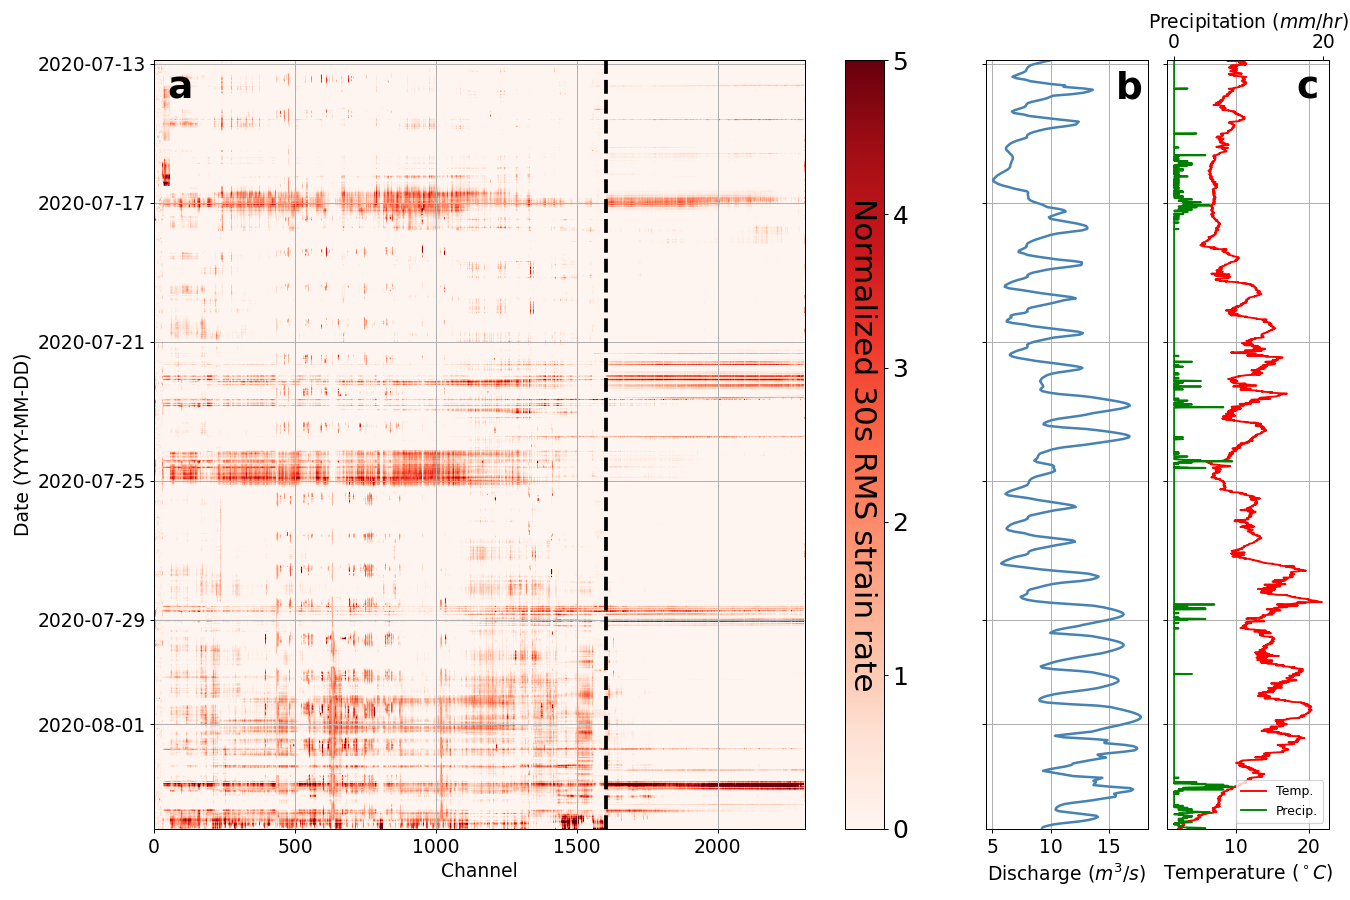

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
%matplotlib notebook

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols =3, figsize = [15,10], gridspec_kw={'width_ratios': [5, 1, 1]})
#fig.suptitle('DAS Deployment on Rhonegletscher, Switzerland', size = 20)
fig.patch.set_facecolor('white')

im = ax1.imshow(normed_das, aspect='auto', extent = [0, 2308,  times[-1], times[0]], vmin=0, vmax=5, cmap='Reds') 
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Normalized 30s RMS strain rate', rotation = '270', labelpad = -25, size = 25)
cbar.ax.tick_params(labelsize=20)
ax1.grid()
ax1.set_xlabel('Channel', size = 15)
ax1.set_ylabel('Date (YYYY-MM-DD)', size = 15)
ax1.yaxis_date()
ax1.set_facecolor("white")

ax2.plot(f['Discharge'][:], times, c='steelblue', lw=2)
ax2.yaxis_date()
ax2.set_ylim([times[0],times[-1]])
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel('Discharge ($m^3/s$)', size = 15)
ax2.set_yticklabels([])
ax2.grid()

ax3.plot(temp, dates_for_temp, color='red', label='Temp.')
ax3.yaxis_date()
ax3.set_ylim([times[0],times[-1]])
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_xlabel('Temperature ($^\circ C$)', size=15)
ax3.set_yticklabels([])
ax3.grid()

ax4 = ax3.twiny()
ax4.plot(precip_per_hour, dates_for_temp, color='green', label='Precip.')
ax4.set_xlabel('Precipitation ($mm/hr$)', size=15)

lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2)

#Add in the ablation/accumulation dilineation

ax1.plot([1602, 1602],[times[0], times[-1]], ls='--', lw=3, color='black')



ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax3.tick_params(labelsize=15)
ax4.tick_params(labelsize=15)


ax1.annotate('a', xy=(.02, .95), xytext=(.02, .95), xycoords='axes fraction', fontsize = 30, weight='bold')
ax2.annotate('b', xy=(.75, .95), xytext=(.8, .95), xycoords='axes fraction', fontsize = 30, weight='bold')
ax3.annotate('c', xy=(.75, .95), xytext=(.8, .95), xycoords='axes fraction', fontsize = 30, weight='bold')

plt.tight_layout()
#plt.show()
fig.savefig('rhone_fig2.eps')
#fig.savefig('rhone_fig2.pdf', facecolor='w', dpi=300)

In [ ]:
f['Times'][-1]

In [ ]:
df_all_chan

In [ ]:
# from scipy import signal
# import h5py
# import numpy as np
# import pickle

# sample_rate = 1e3
# channel_spacing = 4

# with h5py.File('idas2_UTC_20200804_001520.542_rhone1khz.hdf5', 'r') as data:
#     data_retrieved = 116. / 8192. * sample_rate / 10. * np.transpose(np.array(data['/raw_das_data']))

#     data_detrended = signal.detrend(data_retrieved,axis=1)

#     sos = signal.butter(2, 100, 'highpass', fs = 1000, output='sos')
#     filtered = signal.sosfilt(sos, data_detrended)
#     rms = np.sqrt(np.mean((filtered)**2,axis=1))

In [ ]:
mean_chans = np.mean(normed_das, axis=0)

fig,ax = plt.subplots()
ax.plot(mean_chans)